# Étape 1 — Collecte & organisation du dataset 



1. Importer les dépendances

In [ ]:
from dotenv import load_dotenv
import os
import kagglehub
import shutil
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import rgb_to_hsv
import cv2
from sklearn.preprocessing import StandardScaler

2. Load kaggle api key from .env file

In [ ]:
# Load .env first
load_dotenv(override=True, verbose=True)

# verify where is the kaggle config dir
print("KAGGLE_CONFIG_DIR:", os.getenv("KAGGLE_CONFIG_DIR"))
# verify where kaggle will cache datasets
print("KAGGLEHUB_CACHE:", os.getenv("KAGGLEHUB_CACHE"))

KAGGLE_CONFIG_DIR: /home/syntaxerror/India S5/Computer vision/DL-1/svm-nature-scene-classifier
KAGGLEHUB_CACHE: /home/syntaxerror/India S5/Computer vision/DL-1/svm-nature-scene-classifier


3. Télécharger le dataset Kaggle avec kagglehub

In [2]:
import kagglehub

# Download the latest version of the dataset
path = kagglehub.dataset_download("prithivsakthiur/multilabel-geoscenenet-16k")

print("Path to dataset files:", path)

100%|██████████| 214M/214M [03:27<00:00, 1.08MB/s] 

Extracting files...


Path to dataset files: /home/syntaxerror/India S5/Computer vision/DL-1/svm-nature-scene-classifier/datasets/prithivsakthiur/multilabel-geoscenenet-16k/versions/1


4. Déplacer les données du dossier du jeu de données Kaggle installé vers le dossier data

In [5]:
# Entrez le dossier GeoSceneNet16K 
geo_folder = os.path.join(path, "GeoSceneNet16K")

# Le chemin du dossier cible où les dossiers seront déplacés
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
data_dir = os.path.join(project_root, "data")
os.makedirs(data_dir, exist_ok=True)  # create if it doesn't exist

# La liste des dossiers à déplacer
folders_to_move = ["Sea or Ocean", "Forest Area", "Desert"]

# Boucle pour déplacer chaque dossier
for folder_name in folders_to_move:
    src_path = os.path.join(geo_folder, folder_name)
    dest_path = os.path.join(data_dir, folder_name)
    
    if os.path.exists(src_path):
        # Supprimer le dossier de destination s'il existe déjà
        if os.path.exists(dest_path):
            shutil.rmtree(dest_path)
        shutil.move(src_path, dest_path)
        print(f"Moved '{folder_name}' to '{data_dir}'")
    else:
        print(f"Folder '{folder_name}' does not exist in '{geo_folder}'")

Moved 'Sea or Ocean' to '/home/syntaxerror/India S5/Computer vision/DL-1/svm-nature-scene-classifier/data'
Moved 'Forest Area' to '/home/syntaxerror/India S5/Computer vision/DL-1/svm-nature-scene-classifier/data'
Moved 'Desert' to '/home/syntaxerror/India S5/Computer vision/DL-1/svm-nature-scene-classifier/data'


In [7]:
# supprimer le dossier temporaire téléchargé
kaggle_data_dir = os.path.join(project_root, "datasets")
shutil.rmtree(kaggle_data_dir)

5. Garder et renommer les dossiers selon les classes souhaitées

In [8]:
# Correspondance Anglais -> Français
rename_map = {
    "Sea or Ocean": "mer",
    "Forest Area": "paysage",
    "Desert": "desert"
}

# Rename folders
for old_name, new_name in rename_map.items():
    old_path = os.path.join(data_dir, old_name)
    new_path = os.path.join(data_dir, new_name)
    
    if os.path.exists(old_path):
        os.rename(old_path, new_path)
        print(f"Renamed '{old_name}' → '{new_name}'")
    else:
        print(f"'{old_name}' not found in {data_dir}")

Renamed 'Sea or Ocean' → 'mer'
Renamed 'Forest Area' → 'paysage'
Renamed 'Desert' → 'desert'


6. Renommer les images (mer1.jpg, mer2.jpg, ...)

In [9]:
for cls in rename_map.values():
    folder_path = os.path.join(data_dir, cls)
    images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    for idx, img in enumerate(images, 1):
        ext = os.path.splitext(img)[1]
        new_name = f"{cls}{idx}{ext}"
        os.rename(os.path.join(folder_path, img), os.path.join(folder_path, new_name))


7. Equilibrage du dataset

In [ ]:
# Nombre d'images maximum à garder
MAX_IMAGES = 2000

# Parcourir chaque sous-dossier
for folder in rename_map.values():
    folder_path = os.path.join(data_dir, folder)

    if os.path.isdir(folder_path):
        # Récupère toutes les images 
        images = [f for f in os.listdir(folder_path)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        count = len(images)

        # Supprime aléatoirement si plus que MAX_IMAGES
        if count > MAX_IMAGES:
            to_delete = count - MAX_IMAGES
            delete_samples = random.sample(images, to_delete)

            for img in delete_samples:
                os.remove(os.path.join(folder_path, img))



mer: 2274 images
paysage: 2271 images
desert: 2000 images


In [ ]:
# Verifier le nombre d'images dans chaque dossier
for folder in rename_map.values():
    folder_path = os.path.join(data_dir, folder)

    if os.path.isdir(folder_path):
        # Récupère toutes les images 
        images = [f for f in os.listdir(folder_path)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        count = len(images)
        print(f"{folder}: {count} images")

mer: 2000 images
paysage: 2000 images
desert: 2000 images


8. Vérification et redimensionnement à 128x128

In [16]:
def check_and_resize(data_dir, classes, size=(128,128)):
    for cls in classes:
        folder = os.path.join(data_dir, cls)
        images = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        valid_images = []
        for img_name in images:
            img_path = os.path.join(folder, img_name)
            try:
                img = Image.open(img_path)
                img.verify()  # Vérifie la lisibilité
                # Redimensionnement
                img = Image.open(img_path).convert('RGB')
                img = img.resize(size)
                img.save(img_path)
                valid_images.append(img_name)
            except Exception as e:
                print(f"Image corrompue : {img_path}")
        print(f"{cls}: {len(valid_images)} images valides")

# Utiliser la bonne liste de classes françaises :
classes = rename_map.values()
check_and_resize(data_dir, classes)


mer: 2000 images valides
paysage: 2000 images valides
desert: 2000 images valides


# Étape 2 — Exploration et visualisation

1. Sélectionner une image par classe

In [45]:
sample_images = {}
for cls in classes:
    folder = os.path.join(data_dir, cls)
    images = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    sample_images[cls] = random.choice(images)

2. Obtenir l'histogramme RGB

In [46]:
def get_rgb_histograms(img_bgr):
    hist_list = []
    for i in range(3):  # BGR channels
        hist = cv2.calcHist([img_bgr], [i], None, [16], [0,256])
        hist = hist.ravel() / hist.sum()  # Normalisation (somme=1)
        hist_list.append(hist)
    return hist_list

3. Obtenir l'histogramme HSV

In [47]:
def get_hsv_histograms(img_bgr):
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    bins = [16, 16, 16]
    ranges = [(0,180), (0,256), (0,256)]
    hsv_hist = []
    for i, b, rng in zip(range(3), bins, ranges):
        hist = cv2.calcHist([img_hsv], [i], None, [b], [rng[0], rng[1]])
        hist = hist.ravel() / hist.sum()
        hsv_hist.append(hist)
    return hsv_hist, img_hsv

4. Subplot combiné image + RGB + HSV

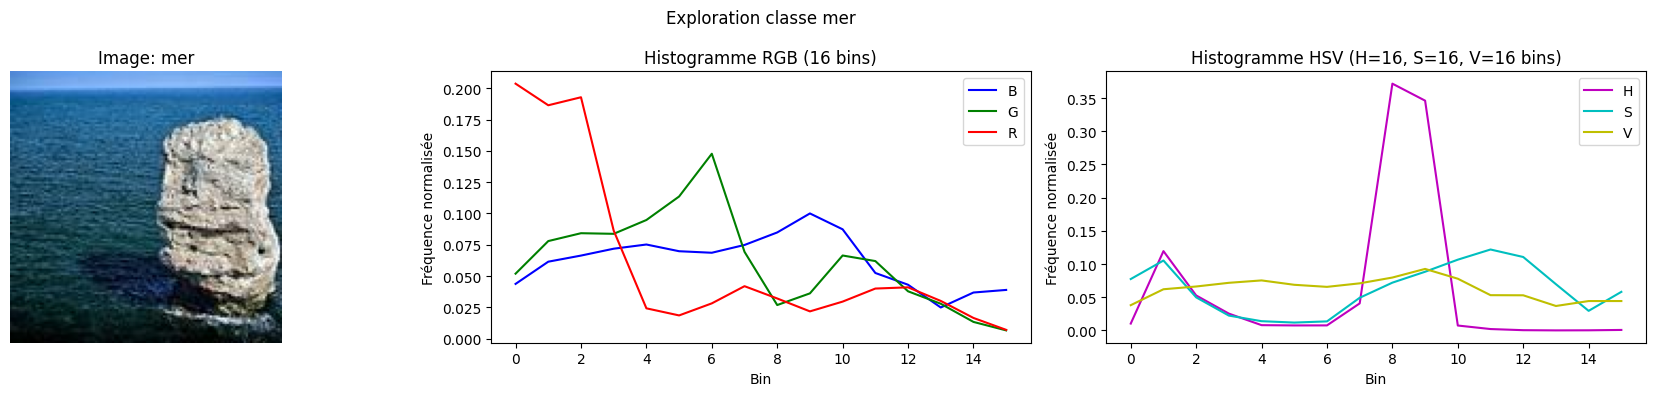

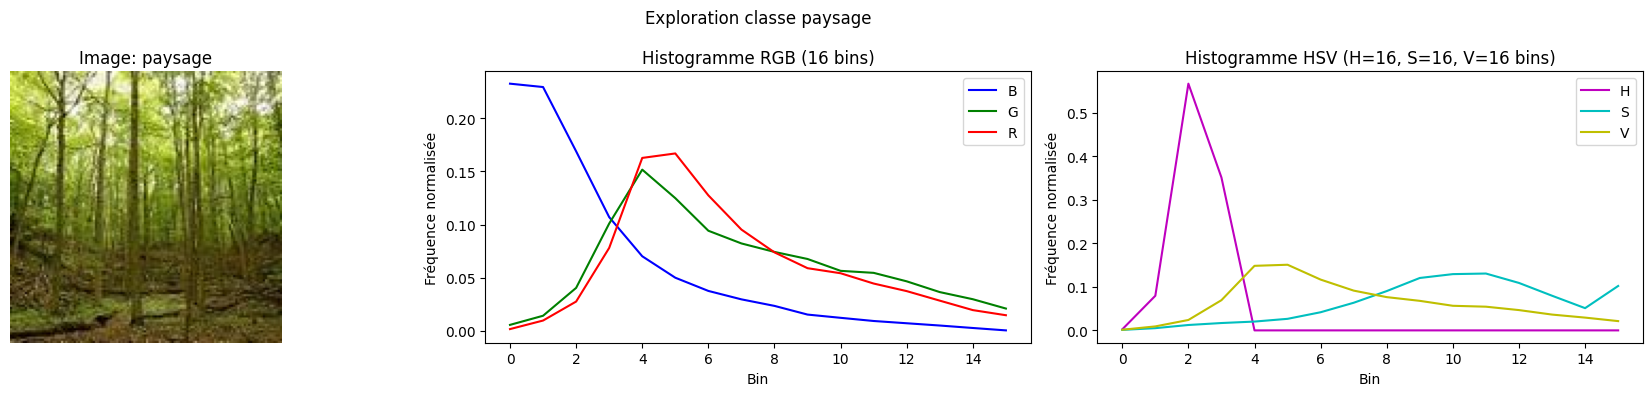

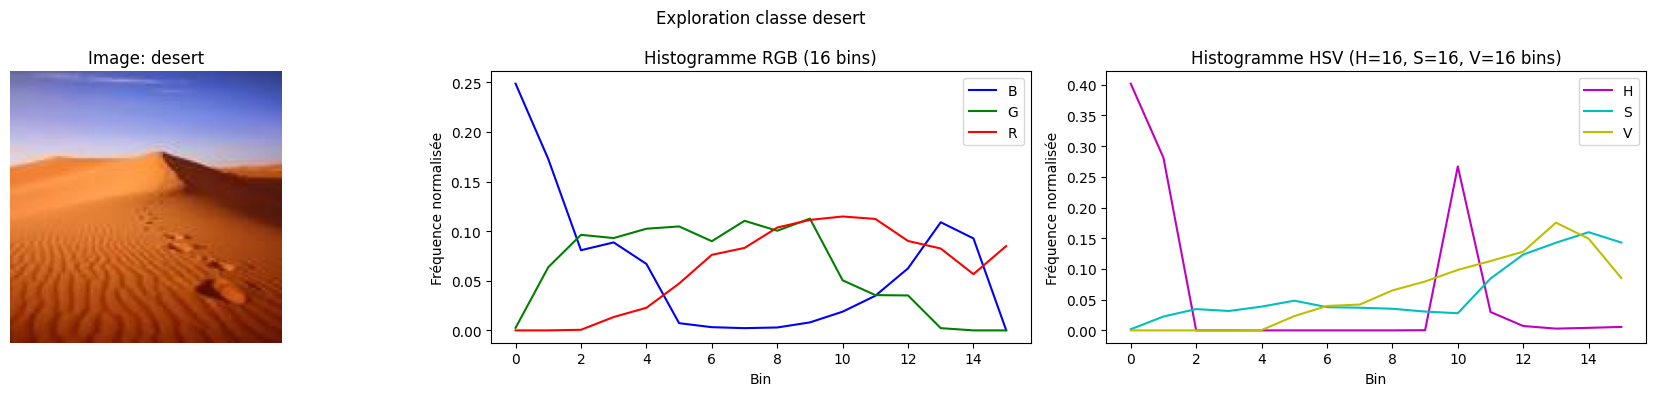

In [48]:
for cls in classes:
    img_path = os.path.join(data_dir, cls, sample_images[cls])
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    rgb_hist = get_rgb_histograms(img_bgr)
    hsv_hist, img_hsv = get_hsv_histograms(img_bgr)

    fig, axs = plt.subplots(1, 3, figsize=(18, 4))
    axs[0].imshow(img_rgb)
    axs[0].set_title(f'Image: {cls}')
    axs[0].axis('off')

    # RGB
    for i, c in enumerate(['b', 'g', 'r']):
        axs[1].plot(np.arange(16), rgb_hist[i], color=c, label=c.upper())
    axs[1].set_title('Histogramme RGB (16 bins)')
    axs[1].set_xlabel('Bin')
    axs[1].set_ylabel('Fréquence normalisée')
    axs[1].legend()

    # HSV
    hsv_bin_sizes = [16, 16, 16]
    hsv_labels = ['H', 'S', 'V']
    hsv_colors = ['m', 'c', 'y']
    for i in range(3):
        axs[2].plot(np.arange(hsv_bin_sizes[i]), hsv_hist[i], color=hsv_colors[i], label=hsv_labels[i])
    axs[2].set_title('Histogramme HSV (H=16, S=16, V=16 bins)')
    axs[2].set_xlabel('Bin')
    axs[2].set_ylabel('Fréquence normalisée')
    axs[2].legend()
    plt.suptitle(f'Exploration classe {cls}')
    plt.tight_layout()
    plt.show()


5. Moyennes/écarts-types HSV pour chaque image

In [ ]:
for cls in classes:
    img_path = os.path.join(data_dir, cls, sample_images[cls])
    img_bgr = cv2.imread(img_path)
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    h, s, v = [img_hsv[...,i].astype(np.float32) for i in range(3)]
    print(f"Classe {cls} — Image {sample_images[cls]}")
    print(f"Moyenne H : {np.mean(h):.2f} / écarts-type  = {np.std(h):.2f}")
    print(f"Moyenne S : {np.mean(s):.2f} / écarts-type  = {np.std(s):.2f}")
    print(f"Moyenne V : {np.mean(v):.2f} / écarts-type = {np.std(v):.2f}\n")


Classe mer — Image mer1950.jpg
Moyenne H : 82.82 / écarts-type  = 32.42
Moyenne S : 137.56 / écarts-type  = 75.23
Moyenne V : 122.34 / /écarts-type = 66.91

Classe paysage — Image paysage1188.jpg
Moyenne H : 30.37 / écarts-type  = 4.92
Moyenne S : 169.94 / écarts-type  = 51.02
Moyenne V : 121.16 / /écarts-type = 53.40

Classe desert — Image desert1600.jpeg
Moyenne H : 45.23 / écarts-type  = 51.66
Moyenne S : 176.66 / écarts-type  = 66.61
Moyenne V : 188.59 / /écarts-type = 42.33



# Étape 3 — Intervalles de couleurs & vecteurs de features 

1. Définir les intervalles de teintes dominantes 

In [1]:
# Intervalles de teintes H basés sur les histogrammes de l'étape 2
hue_ranges = {
    'mer': (100, 140),
    'paysage': (50, 90),
    'desert': (10, 40)
}

2. Fonction extract_color_features

In [3]:
def extract_color_features(img_path):
    img = cv2.imread(img_path)
    
    # RGB histograms + stats
    rgb_hists = []
    rgb_stats = []
    for i in range(3):
        hist = cv2.calcHist([img], [i], None, [16], [0,256])
        hist = hist.ravel() / hist.sum()
        rgb_hists.append(hist)
        rgb_stats.extend([img[...,i].mean(), img[...,i].std()])
    rgb_features = np.concatenate(rgb_hists + [rgb_stats])
    
    # HSV histograms + stats + hue ratios
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv_bins = [36, 16, 16]
    hsv_ranges = [(0,180), (0,256), (0,256)]
    hsv_hists = []
    hsv_stats = []
    for i, b, rng in zip(range(3), hsv_bins, hsv_ranges):
        hist = cv2.calcHist([img_hsv], [i], None, [b], [rng[0], rng[1]])
        hist = hist.ravel() / hist.sum()
        hsv_hists.append(hist)
        hsv_stats.extend([img_hsv[...,i].mean(), img_hsv[...,i].std()])
    
    # Hue ratios
    h_channel = img_hsv[...,0]
    total_pixels = h_channel.size
    hue_ratios = []
    for cls, (h_min, h_max) in hue_ranges.items():
        ratio = np.sum((h_channel >= h_min) & (h_channel < h_max)) / total_pixels
        hue_ratios.append(ratio)
    
    hsv_features = np.concatenate(hsv_hists + [hsv_stats, hue_ratios])
    
    return rgb_features, hsv_features


3. Construire X_rgb, X_hsv, y

In [5]:
classes = ['mer', 'paysage', 'desert']
label_map = {'mer': 0, 'paysage': 1, 'desert': 2}

X_rgb_list = []
X_hsv_list = []
y_list = []

for cls in classes:
    project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
    data_dir = os.path.join(project_root, "data")
    folder = os.path.join(data_dir, cls)
    images = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    for img_name in images:
        img_path = os.path.join(folder, img_name)
        rgb_feat, hsv_feat = extract_color_features(img_path)
        X_rgb_list.append(rgb_feat)
        X_hsv_list.append(hsv_feat)
        y_list.append(label_map[cls])

X_rgb = np.array(X_rgb_list)
X_hsv = np.array(X_hsv_list)
y = np.array(y_list)
